In [1]:
import csv, string, nltk, collections, os
import pandas as pd
import numpy as np

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

from scipy.sparse import csr_matrix
from scipy.stats import wasserstein_distance

from timeit import default_timer as timer

from pyemd import emd

import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AndraIonescu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AndraIonescu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AndraIonescu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Phase one
Computing distribution clusters

### Read data

In [2]:
# Read data
data_imdb = pd.read_csv('movies3/csv_files/imdb.csv')
data_rt = pd.read_csv('movies3/csv_files/rotten_tomatoes.csv')

# Clean data
data_imdb = data_imdb.fillna(0)
data_rt = data_rt.fillna(0)
data_rt = data_rt.replace({'Rating': ['N', '.']}, {'Rating': 0})

# Store data for future processing 
data1 = data_imdb
data2 = data_rt

# Get the columns
columns1 = data1.columns
columns2 = data2.columns

### Dummy numerical data based on the imdb data

In [3]:
dataX = pd.DataFrame(data1.Rating)
dataX.columns = ['Score']
dataX = dataX.reindex(np.random.permutation(dataX.index)).reset_index()
dataX['Rating'] = data1.Rating

### Small test data and CountVectorizer test

In [4]:
d1 = "Obama speaks to the media in Illinois"
d2 = "The President addresses the press in Chicago"

vect = CountVectorizer(stop_words="english").fit([d1, d2])
print("Features:",  ", ".join(vect.get_feature_names()))

Features: addresses, chicago, illinois, media, obama, president, press, speaks


### TPC-H Data

In [7]:
customer = pd.read_csv('tpch/customer.csv', sep='|', header=None)
# lineitem = pd.read_csv('tpch/lineitem.csv', sep='|', header=None)
nation = pd.read_csv('tpch/nation.csv', sep='|', header=None)
orders = pd.read_csv('tpch/orders.csv', sep='|', header=None)
part = pd.read_csv('tpch/part.csv', sep='|', header=None)
region = pd.read_csv('tpch/region.csv', sep='|', header=None)
supplier = pd.read_csv('tpch/supplier.csv', sep='|', header=None)
partsupp = pd.read_csv('tpch/partsupp.csv', sep='|', header=None)

### Get the google news vocabulary and store it as a memory map
The function returns an array:
- result[0] the data map
- result[1] the vocabulary map

Download the data from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [9]:
def get_vocabulary():
    if not os.path.exists("data/embed.dat"):
        print("Caching word embeddings in memmapped format...")
        from gensim.models import KeyedVectors
        wv = KeyedVectors.load_word2vec_format(
            "GoogleNews-vectors-negative300.bin.gz", binary=True)
        wv.init_sims()
        from tempfile import mkdtemp
        import os.path as path
        dat_file = path.join(mkdtemp(), 'embed.dat')
        vocab_file = path.join(mkdtemp(), 'embed.vocab')
        fp = np.memmap(dat_file, dtype=np.double, mode='w+', shape=wv.vectors_norm.shape)
        fp[:] = wv.vectors_norm[:]
        with open(vocab_file, "w+") as f:
            for _, w in sorted((voc.index, word) for word, voc in wv.vocab.items()):
                print(w, file=f)
        del fp, wv

    W = np.memmap(dat_file, dtype=np.double, mode="r", shape=(3000000, 300))
    with open(vocab_file) as f:
        vocab_list = map(str.strip, f.readlines())

    return [W, {w: k for k, w in enumerate(vocab_list)}]

In [6]:
result = get_vocabulary()
W = result[0]
vocab_dict = result[1]

Caching word embeddings in memmapped format...


### Algorithm 1 from the paper 
Algorithmically identifying the cutoff EMD threshold for a column C, given a global threshold. 

In [10]:
def compute_cutoff_threshold(C, threshold):
    t = {}
    t['e'] = threshold
    t['c'] = 0
    C.append(t)
    C = sorted(C, key = lambda i: i['e']) 
    cutoff = 0
    gap = 0.0
    i = 0
    while C[i + 1]['e'] <= threshold:
        if gap < (C[i+1]['e'] - C[i]['e']):
            gap = C[i+1]['e'] - C[i]['e']
            cutoff = C[i]['e']
        i += 1

    return cutoff      

### Get the neighbors of a column
The neighborhood NC of column C consists of all columns C′ with EMD(C, C′) ≤ cutoff.

In [11]:
def get_neighbors(C, cutoff):
    return [i['c'] for i in C if i['e'] <= cutoff]

### Algorithm 2 from the paper
Compute distribution graph and distribution cluster. 

In [12]:
def compute_distribution_clusters(data, columns, threshold):
    graph = {}
    A = {}
#     vocab_dict = get_vocabulary()
  
    for i in range(0, len(columns)):
        for j in range(i + 1, len(columns)):
            try:
                e = wasserstein_distance(data[columns[i]], data[columns[j]])
            except ValueError:
                e = word_emd(data[columns[i]], data[columns[j]], vocab_dict)
            item_j = {}
            item_j['e'] = e
            item_j['c'] = columns[j]
            if columns[i] not in A:
                A[columns[i]] = []
            A[columns[i]].append(item_j)

            item_i = {}
            item_i['e'] = e
            item_i['c'] = columns[i]
            if columns[j] not in A:
                A[columns[j]] = []
            A[columns[j]].append(item_i)
        graph[columns[i]] = []
    
    for i in range(len(columns)):
        theta = compute_cutoff_threshold(A[columns[i]], threshold)
        Nc = get_neighbors(A[columns[i]], theta)

        for c in Nc:
            graph[columns[i]] = c
      
    return graph


### Word EMD 
Word EMD algortihm according to: https://vene.ro/blog/word-movers-distance-in-python.html which is based on the paper: http://mkusner.github.io/publications/WMD.pdf

In [13]:
def word_emd(d1, d2, vocab_dict):
    corpus = d1 + d2
    l1 = len(d1)

    vect = CountVectorizer(stop_words="english").fit(corpus)
    W_ = W[[vocab_dict[w] if w in vocab_dict else vocab_dict['unk'] for w in vect.get_feature_names()] ]
    D_ = euclidean_distances(W_)
    D_ = D_.astype(np.double)
    D_ /= D_.max() 
    
    v_ = vect.transform(corpus)
    v_1 = v_[:l1,:]
    v_2 = v_[l1:, :]
    
    print(v_1.shape)
    print(v_1)
    print(v_2.shape)
    print(v_2)
    
    v_1 = v_1.toarray().ravel()
    v_2 = v_2.toarray().ravel()
    v_1 = v_1.astype(np.double)
    v_2 = v_2.astype(np.double)
    v_1 /= v_1.sum()
    v_2 /= v_2.sum()
    
    print(v_1.shape)
    print(v_2.shape)
    print(D_.shape)
    
    from pyemd import emd

    return [emd(v_1, v_2, D_), vect.get_feature_names()]

### Test the methods given different data

In [21]:
threshold = 0.14

g = compute_distribution_clusters(dataX, dataX.columns, threshold)
# g = compute_distribution_clusters(data1, data1.columns, threshold)

print(g)

{'index': [], 'Score': 'Rating', 'Rating': 'Score'}


In [114]:
# d1 = 'Massimo Morini'
# d2 = 'Beppe Mecconi'

# e = word_emd(data1['Director'].astype(str).tolist(), data1['Creators'].astype(str).tolist(), vocab_dict)
e = word_emd([d1], [d2], vocab_dict)
print(e)
# data1['Creators'].tolist() + data1['Director'].tolist()

(1, 8)
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 7)	1
(1, 8)
  (0, 0)	1
  (0, 1)	1
  (0, 5)	1
  (0, 6)	1
(8,)
(8,)
(8, 8)
[0.744844, ['addresses', 'chicago', 'illinois', 'media', 'obama', 'president', 'press', 'speaks']]


In [13]:
d11 = nltk.word_tokenize(d1.lower())
d12 = nltk.word_tokenize(d2.lower())

print(d11)
print(d12)

uni = set(d11).union(set(d12))
sort = sorted(list(uni))
print(sort)
del sort[3]
del sort[8]
del sort[8]

wmap = {key: i for (i, key) in enumerate(sort)}
print(wmap)

['obama', 'speaks', 'to', 'the', 'media', 'in', 'illinois']
['the', 'president', 'addresses', 'the', 'press', 'in', 'chicago']
['addresses', 'chicago', 'illinois', 'in', 'media', 'obama', 'president', 'press', 'speaks', 'the', 'to']
{'addresses': 0, 'chicago': 1, 'illinois': 2, 'media': 3, 'obama': 4, 'president': 5, 'press': 6, 'speaks': 7}


### Copied wasserstein distance code from python repo

In [16]:
def _cdf_distance(p, u_values, v_values, u_weights=None, v_weights=None):
    r"""
    Compute, between two one-dimensional distributions :math:`u` and
    :math:`v`, whose respective CDFs are :math:`U` and :math:`V`, the
    statistical distance that is defined as:
    .. math::
        l_p(u, v) = \left( \int_{-\infty}^{+\infty} |U-V|^p \right)^{1/p}
    p is a positive parameter; p = 1 gives the Wasserstein distance, p = 2
    gives the energy distance.
    Parameters
    ----------
    u_values, v_values : array_like
        Values observed in the (empirical) distribution.
    u_weights, v_weights : array_like, optional
        Weight for each value. If unspecified, each value is assigned the same
        weight.
        `u_weights` (resp. `v_weights`) must have the same length as
        `u_values` (resp. `v_values`). If the weight sum differs from 1, it
        must still be positive and finite so that the weights can be normalized
        to sum to 1.
    Returns
    -------
    distance : float
        The computed distance between the distributions.
    Notes
    -----
    The input distributions can be empirical, therefore coming from samples
    whose values are effectively inputs of the function, or they can be seen as
    generalized functions, in which case they are weighted sums of Dirac delta
    functions located at the specified values.
    References
    ----------
    .. [1] Bellemare, Danihelka, Dabney, Mohamed, Lakshminarayanan, Hoyer,
           Munos "The Cramer Distance as a Solution to Biased Wasserstein
           Gradients" (2017). :arXiv:`1705.10743`.
    """
#     u_values, u_weights = _validate_distribution(u_values, u_weights)
#     v_values, v_weights = _validate_distribution(v_values, v_weights)

    u_sorter = np.argsort(u_values)
    v_sorter = np.argsort(v_values)

    all_values = np.concatenate((u_values, v_values))
    all_values.sort(kind='mergesort')

    # Compute the differences between pairs of successive values of u and v.
    deltas = np.diff(all_values)

    # Get the respective positions of the values of u and v among the values of
    # both distributions.
    u_cdf_indices = u_values[u_sorter].searchsorted(all_values[:-1], 'right')
    v_cdf_indices = v_values[v_sorter].searchsorted(all_values[:-1], 'right')

    # Calculate the CDFs of u and v using their weights, if specified.
    if u_weights is None:
        u_cdf = u_cdf_indices / u_values.size
    else:
        u_sorted_cumweights = np.concatenate(([0],
                                              np.cumsum(u_weights[u_sorter])))
        u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

    if v_weights is None:
        v_cdf = v_cdf_indices / v_values.size
    else:
        v_sorted_cumweights = np.concatenate(([0],
                                              np.cumsum(v_weights[v_sorter])))
        v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]

    # Compute the value of the integral based on the CDFs.
    # If p = 1 or p = 2, we avoid using np.power, which introduces an overhead
    # of about 15%.
    if p == 1:
        return np.sum(np.multiply(np.abs(u_cdf - v_cdf), deltas))
    if p == 2:
        return np.sqrt(np.sum(np.multiply(np.square(u_cdf - v_cdf), deltas)))
    return np.power(np.sum(np.multiply(np.power(np.abs(u_cdf - v_cdf), p),
                                       deltas)), 1/p)

### Same algorithm as above
Tried to make it work for strings - NOT WORKING

In [191]:
u_sorter = np.argsort(u)
print(u_sorter)
v_sorter = np.argsort(v)
print(v_sorter)

all_values = np.concatenate((u, v))
all_values = np.array(list(set(all_values)))

all_args = np.argsort(all_values)
print(all_args)
print(all_values)
all_values.sort(kind='mergesort')
print(all_values)

# uni = set(d11).union(set(d12))
# sort = sorted(list(uni))
# print(list(uni))
# print(sort)

# arg = np.argsort(list(uni))
# print(arg)

fv = np.vectorize(nltk.edit_distance)
deltas = fv(all_values[:-1], all_values[1:])
# deltas = np.diff(all_args)
# deltas = np.diff(all_values)
print(deltas)

u_cdf_indices = np.array(u)[u_sorter].searchsorted(all_values[:-1], 'right')
v_cdf_indices = np.array(v)[v_sorter].searchsorted(all_values[:-1], 'right')

# print(all_values[:-1])

# print(np.array(u)[u_sorter])
# print(v[v_sorter])

# print(u_cdf_indices)
# print(v_cdf_indices)

u_cdf = u_cdf_indices / np.array(u).size
v_cdf = v_cdf_indices / np.array(v).size

# print(u_cdf)
# print(v_cdf)

np.sum(np.multiply(np.abs(u_cdf - v_cdf), deltas))
# np.sum(np.abs(u_cdf - v_cdf))

[0 1 2]
[1 0 2]
[3 0 4 2 1]
['i' 'popcorn' 'like' 'bike' 'iou']
['bike' 'i' 'iou' 'like' 'popcorn']
[3 2 3 7]


2.0

### Quantile histogram algorithm
Copied from https://cobr.io/blog/implementing-a-multi-column-foreign-key-discovery-algorithm.html

NOT WORKING as expected

In [14]:
import math
def quantilehistogram(values, numbins=256):
        try:
            lists = [list(t) for t in zip(*values)] # unpack pairs of values into a list of lists
        except:
            lists = [list(t) for t in zip(values)]

        if len(lists) == 0: # empty column...
            return None

        hists = []
        for l in lists:
            binsize = int(math.sqrt(len(l)))
            if binsize >= 500:
                binsize = 499

            hist = []
            bins = []
            try:
                # print('trying as is..')
                sum(l)
                hist, bins = np.histogram(l, bins=binsize, density=True) # sqrt to improve accuracy for larger tables
            except:
                try:
                    # print('trying to cast to ints..')
                    castlist = [ int(value) for value in l ]
                    hist, bins = np.histogram(castlist, bins=binsize, density=True)
                except:
                    # print('trying as is hashed..')
                    hashedlist = [ hash(value) for value in l ]
                    hist, bins = np.histogram(hashedlist, bins=binsize, density=True)
                # c = collections.Counter(l)
                # rhist = list(map((lambda x: x/len(l)), list(c.values()))) # for each quantile (map) divide by total number of records to get probability
                # rbins = list(c)

                # for i in range(numbins):
                # 	if i < len(rhist) and i < len(rbins):
                # 		hist.append(rbins[i])
                # 		bins.append(rhist[i])
                # 	else:
                # 		hist.append(0)
                # 		bins.append(0)
                # bins.append(0)
            hists.append((list(hist), list(bins)))

        return hists

### Quantile EMD
Source: https://cobr.io/blog/implementing-a-multi-column-foreign-key-discovery-algorithm.html

NOT WORKING as expected

In [15]:
def q_emd(qfk, qpk):
    emdscore = 0
    for i in range(len(qfk)):
        fkhist = qfk[i][0]
        pkhist = qpk[i][0]

        fkbins = qfk[i][1]
        pkbins = qpk[i][1]
#         print(np.transpose(np.array(fkhist)))
        emdscore += emd(np.transpose(np.array(fkhist)), np.transpose(np.array(pkhist)), 
                        np.ascontiguousarray(np.array([fkbins[0:-1], pkbins[0:-1]]).T))
    emdscore = emdscore/len(qfk[0])
    return emdscore

In [54]:
# hist1 = quantilehistogram(data1['Title'][:100])
# hist2 = quantilehistogram(data2['Title'][:100])

hist1 = quantilehistogram(d11)
hist2 = quantilehistogram(d12)

# hist2 = quantilehistogram(dataX['Score'][:100])
# q_emd(hist1, hist2)

In [ ]:
q_emd(hist1, hist2)
# np.array([hist1[1][1][0:-1], hist2[1][1][0:-1]]).T.shape
# np.concatenate((np.array(hist1[1][1][0:-1]), np.array(hist2[1][1][0:-1])))

# dataX['Score'][:100]

### Equi-depth quantile histogram
According to the paper, this is how they analysed the distributions of 2 columns

WORK IN PROGRESS

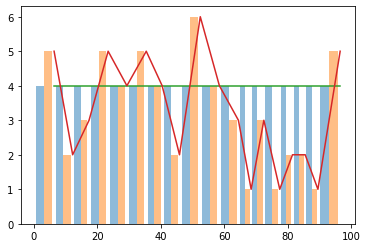

In [25]:
import functools, operator
from scipy import stats

# psc = np.array(partsupp['PS_Comment'][0:10])
psc = np.array(partsupp[4][0:10])

# custc = customer['C_Comment'][0:10]
custc = customer[7][0:10]

table = str.maketrans({key: ' ' for key in string.punctuation})
psc = np.char.lower([token.translate(table) for token in psc])
custc = np.char.lower([token.translate(table) for token in custc])

d11 = [nltk.word_tokenize(token) for token in psc]
d11 = functools.reduce(operator.iconcat, d11, [])
d12 = [nltk.word_tokenize(token) for token in custc]
d12 = functools.reduce(operator.iconcat, d12, [])

s11 = set(d11)
s12 = set(d12)

sort = sorted(list(s11.union(s12)))
wmap = {key: i for (i, key) in enumerate(sort)}

# wmap1 = {key: i for (i, key) in enumerate(s11)}

psc_t = sorted([wmap[token]for token in list(s11)])
custc_t = sorted([wmap[token]for token in list(s12)])

rate1 = [i/len(psc_t) for i in range(0, len(psc_t)+1, 4)]
bin_edges1 = stats.mstats.mquantiles(psc_t, rate1)

rate2 = [i/len(custc_t) for i in range(0, len(custc_t)+1, 4)]
bin_edges2 = stats.mstats.mquantiles(custc_t, rate2)

occ1, bins, xx = plt.hist([psc_t, custc_t], bins=bin_edges1, alpha=0.5)

# plot the resultint bins to see the distribution
plt.plot(bins[1:len(bins)], occ1[0])
plt.plot(bins[1:len(bins)], occ1[1])